In [1]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [2]:
import sys

import matplotlib.pyplot as plt

sys.path.append('../scripts')
sys.path.append('../')

from heapq import heappop, heappush
from itertools import count

import time
from multiprocessing import Pool
from time import sleep

import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import graph_osm_loader, utils, clustering

import networkx as nx
import pandas as pd


2024-11-25 21:00:59,327 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
def get_graph():
    dataset = pd.read_csv('../data/graph_data/p2p-Gnutella31.txt', delimiter="\t")
    g = nx.DiGraph()
    nodes = set()
    edges = set()
    for _, r in tqdm(dataset.iterrows(), total=len(dataset.index), desc='read data'):
        f, t = r['# FromNodeId'], r['ToNodeId']
        nodes.add(f)
        nodes.add(t)
        edges.add((f, t))
    for n in tqdm(nodes, desc='add nodes'):
        g.add_node(n)
    for u, v in tqdm(edges, desc='add edges'):
        g.add_edge(u, v, length=1)

    del dataset
    return g

In [4]:
def dijkstra_pfa_min_dst(graph: nx.Graph,
                         start: set[int],
                         ) -> \
        tuple[float, list[int]]:
    adjacency = graph._adj
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    fringe = []
    for s in start:
        dist[s] = 0.0
        push(fringe, (0.0, next(c), s))
    while fringe:
        (d, _, v) = pop(fringe)
        for u, e in adjacency[v].items():
            vu_dist = d + e['length']
            if u not in dist or dist[u] > vu_dist:
                dist[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
    return dist


In [5]:
def get_rand_graph(N, p):
    G = nx.fast_gnp_random_graph(N, p, directed=False)
    if not nx.is_connected(G):
        print('create connected')
        tmp = []
        for n in nx.connected_components(G):
            for q in n:
                tmp.append(q)
                break
        for i in trange(len(tmp) - 1):
            G.add_edge(tmp[i], tmp[i + 1])
    for e in G.edges:
        G.add_edge(e[0], e[1], length=np.random.random_sample() + 0.001)
    for u in G.nodes:
        if u in G[u]:
            G.remove_edge(u, u)
    return G

In [6]:
GRAPH_ID = 'R13470549'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # загрузка графа
N = 1000_00
p = 3 / N
# g = get_rand_graph(N,p)
# g = get_graph()
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

715 1038


In [7]:
g.remove_edges_from(nx.selfloop_edges(g))

In [9]:
np.sqrt(len(g.nodes))

26.739483914241877

In [8]:
cms = clustering.resolve_k_means_communities(g, resolution=1, max_iteration=100, cluster_name='cluster1',
                                             print_log=True)
print(len(cms))

2024-11-25 21:01:02,136 - root - INFO - communities: 26


100%|██████████| 100/100 [00:01<00:00, 51.08it/s]

26


In [14]:
import pickle


def calc(data):
    i, points, name, cms, g = data
    d_clusters = np.zeros((len(cms), len(cms)))

    for u in points:
        ll = dijkstra_pfa_min_dst(g, cms[u])
        q = {}
        for v, d in ll.items():
            if g.nodes()[v][name] in q:
                q[g.nodes()[v][name]] = min(q[g.nodes()[v][name]], d)
            else:
                q[g.nodes()[v][name]] = d
        for v in range(len(cms)):
            if v in q:
                d_clusters[u, v] = q[v]
    with open(f'./temp/{i}.pcl', 'wb') as fp:
        pickle.dump(d_clusters, fp)
    del i, points, name, cms, g, d_clusters
    return 0

In [15]:
w = 4

In [16]:
from threading import Semaphore


def generator_data():
    s = Semaphore(w * 2)
    for p in range(len(cms)):
        s.acquire()
        yield ({p}, 'cluster1', cms, g)
        s.release()

In [17]:
cms_points = list(range(len(cms)))
data = [(i, cms_points[i::w], 'cluster1', cms, g) for i in range(w)]

In [18]:
! mkdir temp 

In [19]:

with Pool(w) as p:
    res = list(tqdm(p.imap_unordered(calc, data), total=len(data)))
for i in range(w):
    with open(f'./temp/{i}.pcl', 'rb') as fp:
        d_clusters += pickle.load(fp)

  0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
!rm -rf temp

In [21]:
d_clusters1 = d_clusters
nodes = g.nodes()

In [22]:
d_clusters1.size * d_clusters1.itemsize / 1024 / 1024

0.005157470703125

In [23]:
# p2remove = set()
# for p1,p2 in tqdm(points):
#     try:
#         nx.single_source_dijkstra(g,p1,p2,weight='length')
#     except Exception as e:
#         print(e)
#         p2remove.add((p1,p2))

In [24]:
# len(p2remove)

In [25]:
# p = []
# for p1,p2 in points:
#     if (p1,p2)not  in p2remove:
#         p.append((p1,p2))
# points = p

In [26]:


def dijkstra_pfa(graph: nx.Graph,
                 start: int,
                 end: int,
                 cms: set[int] | None = None) -> \
        tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    adjacency = graph._adj
    nodes = graph.nodes()
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    pred = {}
    fringe = []
    push(fringe, (0.0, next(c), 0, start, None))
    while fringe:
        (d, _, n, v, p) = pop(fringe)
        if v in dist:
            continue
        dist[v] = (d, n)
        pred[v] = p
        if v == end:
            break
        for u, e in adjacency[v].items():
            if cms and nodes[u]['cluster'] not in cms:
                continue
            vu_dist = d + e['length']
            if u not in dist:
                push(fringe, (vu_dist, next(c), n + 1, u, v))
    d, n = dist[end]
    n += 1
    path = [None] * n
    i = n - 1
    e = end
    while i >= 0:
        path[i] = e
        i -= 1
        e = pred[e]
    return d, path, set(dist.keys())


def bi_dijkstra_pfa(graph: nx.Graph,
                    start: int,
                    end: int,
                    cms: set[int] | None = None
                    ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = ({start: (0, 0, None)}, {end: (0, 0, None)})
    fringe = ([], [])
    c = count()

    adjacency = graph._adj
    nodes = graph.nodes()

    push(fringe[0], (0, next(c), 0, start))
    push(fringe[1], (0, next(c), 0, end))

    union_node = None
    union_dst = float('inf')
    while fringe[0] and fringe[1]:
        (d1, _, n1, v1) = pop(fringe[0])
        (d2, _, n2, v2) = pop(fringe[1])
        for u, e in adjacency[v1].items():
            if cms and nodes[u]['cluster'] not in cms:
                continue

            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, n1 + 1, v1)
                push(fringe[0], (vu_dist, next(c), n1 + 1, u))
            if u in dist[1]:
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
        for u, e in adjacency[v2].items():
            if cms and nodes[u]['cluster'] not in cms:
                continue

            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, n2 + 1, v2)
                push(fringe[1], (vu_dist, next(c), n2 + 1, u))
            if u in dist[0]:
                dd = dist[0][u][0] + dist[1][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
        if d1 + d2 > union_dst:
            break

    d1, n1, _ = dist[0][union_node]
    d2, n2, _ = dist[1][union_node]
    path = [0] * (n1 + n2 + 1)
    e = union_node
    i = n1
    while dist[0][e][2] is not None:
        path[i] = e
        i -= 1
        e = dist[0][e][2]
    path[0] = e

    e = union_node
    i = n1
    while dist[1][e][2] is not None:
        path[i] = e
        i += 1
        e = dist[1][e][2]
    path[-1] = e
    return union_dst, path, set(dist[0].keys()).union(set(dist[1].keys()))


In [27]:
def func(u, v):
    return d_clusters1[nodes[v]['cluster1'], nodes[u]['cluster1']]

In [28]:
rad = []
for i, c in enumerate(cms):
    gg = g.subgraph(c)
    rad.append(nx.diameter(gg, weight='length'))

In [29]:
def dijkstra_pfa_cls(graph: nx.Graph,
                     start: int,
                     end: int
                     ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = {start: (0, None)}
    fringe = []
    c1, c2 = nodes[start]['cluster1'], nodes[end]['cluster1']
    l0 = d_clusters1[c1,c2]
    
    c = count()
    adjacency = graph._adj
    push(fringe, (0, next(c), 0, func(start, end), start))

    while fringe:
        (_, _, d1, l1, v1) = pop(fringe)
        if v1 == end:
            break
        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist or dist[u][0] > vu_dist:
                uc = nodes[u]['cluster1']
                lu = d_clusters1[uc, c2]
                print(lu+vu_dist)
                dist[u] = (vu_dist, v1)
                push(fringe, (vu_dist + lu, next(c), vu_dist, lu, u))
    path = [end]
    e = end
    while dist[e][1] is not None:
        e = dist[e][1]
        path = [e] + path
    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    return l, path, set(dist.keys())

In [30]:
def ch_pfa(
        graph: nx.Graph,
        start: int,
        end: int) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    adjacency = graph._adj
    push = heappush
    pop = heappop
    dist = (set(), set())
    fringe = ([], [])
    c = count()

    push(fringe[0], (0, next(c), 0, start))
    push(fringe[1], (0, next(c), 0, end))

    heads = [0, 0]
    seens = ({start: (0, None)}, {end: (0, None)})
    union_node = None
    union_dst = float('inf')
    dir = 1
    while fringe[0] or fringe[1]:
        if fringe[0] and fringe[1]:
            dir = 1 - dir
        elif fringe[0]:
            dir = 0
        else:
            dir = 1

        (_, _, d, v) = pop(fringe[dir])

        heads[dir] = d

        if v in dist[dir]:
            continue

        dist[dir].add(v)

        for u, l in adjacency[v].items():
            vu_dist = d + l['length']
            if u not in dist[dir] and (u not in seens[dir] or seens[dir][u][0] > vu_dist):
                seens[dir][u] = (vu_dist, v)
                l = -(func(start, u) - func(end, u)) / 2 if dir == 1 else (func(start, u) - func(end, u)) / 2
                push(fringe[dir], (vu_dist + l, next(c), vu_dist, u))
                if u in seens[1 - dir]:
                    tpl = seens[1 - dir][u]
                    dd = tpl[0] + vu_dist
                    if dd < union_dst:
                        union_dst = dd
                        union_node = u
        if min(heads) > union_dst:
            break
    path = []

    e = union_node
    while seens[0][e][1] is not None:
        path = [e] + path
        e = seens[0][e][1]
    path = [e] + path

    e = union_node
    while seens[1][e][1] is not None:
        e = seens[1][e][1]
        path += [e]

    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    return l, path


In [31]:
def bi_dijkstra_pfa_cls(graph: nx.Graph,
                        start: int,
                        end: int
                        ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = ({start: (0, None)}, {end: (0, None)})
    fringe = ([], [])
    c = count()
    adjacency = graph._adj

    push(fringe[0], (0, next(c), 0, 0, start))
    push(fringe[1], (0, next(c), 0, 0, end))
    nodes = g.nodes()
    c1, c2 = nodes[start]['cluster1'], nodes[end]['cluster1']
    l0 = d_clusters1[c1, c2]
    union_node = None
    union_dst = float('inf')
    while fringe[0] and fringe[1]:
        (_, _, d1, l1, v1) = pop(fringe[0])
        (_, _, d2, l2, v2) = pop(fringe[1])

        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, v1)
                lu = -(func(u, start) - func(u, end)) / 2
                push(fringe[0], (vu_dist + lu, next(c), vu_dist, lu, u))
                if u in dist[1]:
                    dd = dist[1][u][0] + dist[0][u][0]
                    if dd < union_dst:
                        union_dst = dd
                        union_node = u

        for u, e in adjacency[v2].items():
            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, v2)
                lu = (func(u, start) - func(u, end)) / 2
                push(fringe[1], (vu_dist + lu, next(c), vu_dist, lu, u))
                if u in dist[0]:
                    dd = dist[0][u][0] + dist[1][u][0]
                    if dd < union_dst:
                        union_dst = dd
                        union_node = u
        if d1 + d2 > union_dst:
            break
    d1, _ = dist[0][union_node]
    d2, _ = dist[1][union_node]
    path = []

    e = union_node
    while dist[0][e][1] is not None:
        path = [e] + path
        e = dist[0][e][1]
    path = [e] + path

    e = union_node
    while dist[1][e][1] is not None:
        e = dist[1][e][1]
        path += [e]

    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    return l, path

In [32]:
pos = {u: [d['x'], d['y']] for u, d in g.nodes(data=True)}


In [33]:
dst = dict(tqdm(nx.all_pairs_dijkstra_path_length(g, weight='length'), total=len(cms)))

  0%|          | 0/26 [00:00<?, ?it/s]

In [34]:
for i1, c1 in tqdm(enumerate(cms)):
    for i2, c2 in enumerate(cms):
        if i1 == i2:
            assert d_clusters1[i1, i2] == 0
            continue
        m = 1e100
        for u in c1:
            for v in c2:
                l = dst[u][v]
                m = min(m, l)
        if abs(d_clusters1[i1, i2] - m) > 0.1:
            print(m, d_clusters1[i1, i2])

0it [00:00, ?it/s]

NameError: name 'p1' is not defined

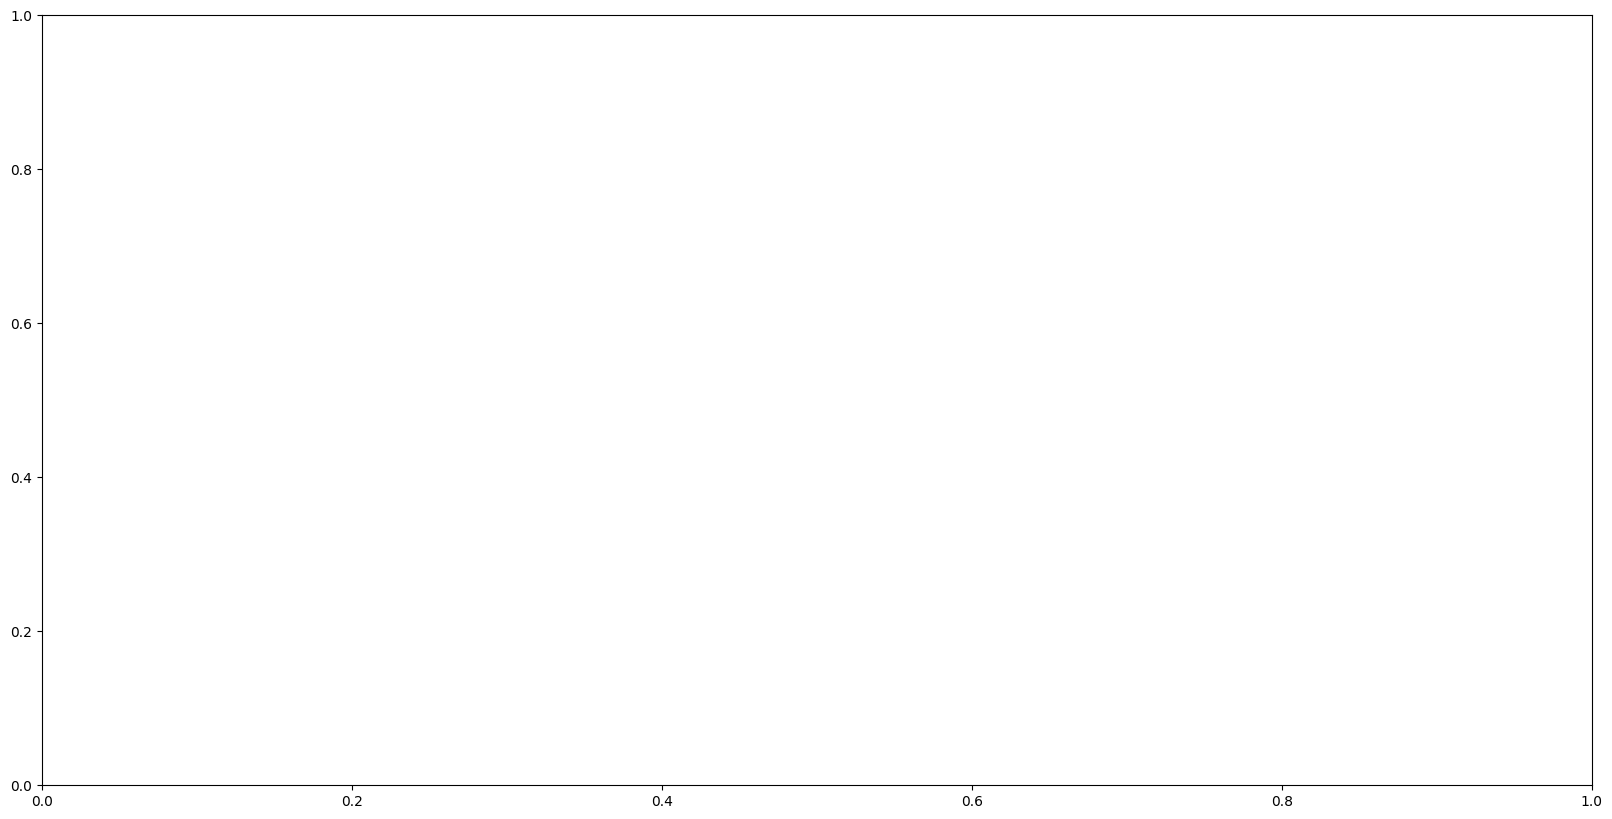

In [35]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
l, path, nn = dijkstra_pfa(g, p1, p2)
f.suptitle('classical')
nx.draw(g, pos=pos, ax=ax, node_size=10, alpha=0.5)
nx.draw(g.subgraph(nn), pos=pos, ax=ax, node_size=10, node_color='green')
nx.draw(g.subgraph(path), pos=pos, ax=ax, node_size=15, node_color='red', edge_color='red', width=2)
nx.draw(g.subgraph(p1), pos=pos, ax=ax, node_size=30, node_color='blue', edge_color='red', width=2)
nx.draw(g.subgraph(p2), pos=pos, ax=ax, node_size=30, node_color='black', edge_color='red', width=2)
# plt.show()

In [ ]:
# f, ax = plt.subplots(1, 1, figsize=(20, 10))
# l, path, nn = bi_dijkstra_pfa(g, p1, p2)
# f.suptitle('bi-directional')
# nx.draw(g, pos=pos, ax=ax, node_size=10, alpha=0.5)
# nx.draw(g.subgraph(nn), pos=pos, ax=ax, node_size=15, node_color='olivedrab', width=2)
# nx.draw(g.subgraph(path), pos=pos, ax=ax, node_size=15, node_color='red', edge_color='red', width=3)
# nx.draw(g.subgraph(p1), pos=pos, ax=ax, node_size=30, node_color='blue', edge_color='red', width=3)
# nx.draw(g.subgraph(p2), pos=pos, ax=ax, node_size=30, node_color='black', edge_color='red', width=3)
# # plt.show()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
p1, p2 = points[11]
l, path, nn = dijkstra_pfa_cls(g, p1, p2)

f.suptitle('bi-dir-cluster-heuristic')
nx.draw(g, pos=pos, ax=ax, node_size=10, alpha=0.5)
nx.draw(g.subgraph(nn), pos=pos, ax=ax, node_size=15, node_color='olivedrab', width=2)
nx.draw(g.subgraph(path), pos=pos, ax=ax, node_size=15, node_color='red', edge_color='red', width=3)
nx.draw(g.subgraph(p1), pos=pos, ax=ax, node_size=30, node_color='red', edge_color='red', width=3)
nx.draw(g.subgraph(p2), pos=pos, ax=ax, node_size=30, node_color='blue', edge_color='red', width=3)
# plt.show()

In [ ]:
# f, ax = plt.subplots(1, 1, figsize=(20, 10))
# l,path,nn = ch_pfa(chg, p1,p2)
# f.suptitle('cluster-heuristic')
# nx.draw(g,pos=pos, ax = ax, node_size = 10, alpha=0.5)
# nx.draw(g.subgraph(nn),pos=pos, ax = ax, node_size = 15, node_color='olivedrab',width = 2)
# nx.draw(g.subgraph(path),pos=pos, ax = ax, node_size = 15, node_color='red', edge_color='red',width = 3)
# nx.draw(g.subgraph(p1),pos=pos, ax = ax, node_size = 30, node_color='blue', edge_color='red',width = 3)
# nx.draw(g.subgraph(p2),pos=pos, ax = ax, node_size = 30, node_color='black', edge_color='red',width = 3)
# # plt.show()

In [ ]:
# for p1,p2 in points:
# print(func(p1, p2), nx.single_source_dijkstra(g, p1, p2, weight='length')[0])    

In [ ]:
points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]

In [ ]:
p1, p2 = points[2]

In [37]:
NUM_ITERATION = 3  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 4  # количество потоков


def do_calc(data):
    pps, i = data

    stat = {}
    stat['l'] = []
    stat['h_l'] = []

    stat['p'] = []
    stat['h_p'] = []
    stat['time_l'] = []
    stat['time_h'] = []

    stat['delta'] = []
    # чисто чтобы tqdm нормально прогрузился 
    sleep(i / 10)
    print('start', i)

    for p1, p2 in tqdm(pps, desc='find paths', position=i):
        if (p1, p2) in stat:
            continue
        # класический дейкстра
        l, p = None, None
        start = time.time()
        for i in range(NUM_ITERATION):
            l, p = nx.single_source_dijkstra(g, p1, p2, weight='length')
        time_l = time.time() - start

        # иерархический
        h_l, h_p = None, None

        start = time.time()
        for _ in range(NUM_ITERATION):
            h_l, h_p, _ = dijkstra_pfa_cls(g, p1, p2)  #find_path_length_h(g, g1,cms, p1, p2)

        time_h = time.time() - start

        delta = (h_l - l) / l * 100
        stat['l'].append(l)  # длина обычного пути
        stat['h_l'].append(h_l)  # длина иерархического пути
        stat['p'].append(p)  # обычный путь
        stat['h_p'].append(h_p)  # иерархический путь
        stat['delta'].append(delta)  # разница в длине
        stat['time_l'].append(time_l)  # обычное время 
        stat['time_h'].append(time_h)  # иерархическое
        break
    return stat


data = [([p for p in points[i::WORKER]], i) for i in range(WORKER)]
do_calc(data[0])
# with Pool(WORKER) as p:
#     res = p.map(do_calc, data)

stat = {}
for l in res:

    for d in l:
        if d not in stat:
            stat[d] = []
        stat[d].extend(l[d])
print(f"err_mean: {np.mean(stat['delta']):.2f} %")
print(f"err_min: {np.min(stat['delta']):.2f} %")
print(f"err_max: {np.max(stat['delta']):.2f} %", )
print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])):.2f} times")

start 0


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

2568.2319999999995
2605.5979999999995
2567.6249999999995
2695.5659999999993
2780.6379999999995
2861.7589999999996
2684.7759999999994
2649.9169999999995
2719.1989999999996
2694.3719999999994
2701.2499999999995
2772.499
2723.0309999999995
2808.9479999999994
2767.0339999999997
4220.375
2782.7919999999995
2809.8889999999997
2781.4949999999994
2742.5139999999997
2881.9119999999994
2877.1179999999995
2850.3719999999994
2890.7219999999998
2925.0999999999995
3050.334
2977.4559999999997
2896.3029999999994
2906.0649999999996
3027.2589999999996
3032.3959999999997
3019.7779999999993
2966.961
3085.968
3054.0219999999995
3060.6289999999995
3078.4509999999996
3175.2929999999997
3133.2029999999995
3157.0689999999995
3131.87
3142.4059999999995
3172.4029999999993
3132.7679999999996
3247.2899999999995
3319.5629999999996
3144.7259999999997
3453.1279999999997
3255.1459999999997
3326.2799999999997
3255.4639999999995
3326.0399999999995
3377.691
3460.2349999999997
3452.4039999999995
3504.6069999999995
3402.61

TypeError: 'int' object is not iterable

In [ ]:
max_err_idx = np.argmax(stat['delta'])


In [ ]:
path = stat['p'][max_err_idx]
h_path = stat['h_p'][max_err_idx]

In [ ]:
path

In [ ]:
h_path

In [ ]:
len(path), len(h_path)

In [ ]:
print(np.array(path) - np.array(h_path))

In [ ]:
stat['l'][max_err_idx], stat['h_l'][max_err_idx]

In [ ]:
p1, p2 = path[0], path[-1]

In [ ]:
g.nodes[p1]['cluster1'],g.nodes[p2]['cluster1']

In [ ]:
labels = {u: d['cluster'] for u, d in g.nodes(data=True)}

In [ ]:
pos_l = {u: [d['x'] + 0.001, d['y'] + 0.001] for u, d in g.nodes(data=True)}
pos = {u: [d['x'], d['y']] for u, d in g.nodes(data=True)}


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
f.suptitle('max_err')

for u, d in g.nodes(data=True):
    d['cluster'] = d['cluster1']

nx.draw(g, pos=pos, ax=ax, node_size=10, alpha=0.5)
nx.draw(g.subgraph(path), pos=pos, ax=ax, node_size=15, node_color='red', width=2, alpha=0.5)
nx.draw(g.subgraph(h_path), pos=pos, ax=ax, node_size=15, node_color='green', width=2, alpha=0.5)
# nx.draw_networkx_labels(g,pos_l,labels=labels,font_size=6)

In [ ]:
nx.single_source_dijkstra(g, p1, p2, weight='length')

In [ ]:
bi_dijkstra_pfa_cls(g, p1, p2)

In [ ]:
893305603 in nx.single_source_dijkstra(g, p1, p2, weight='length')[1]